# Environment Setting

## Import Library

In [1]:
!pip install -U imblearn

Requirement already up-to-date: imblearn in /anaconda/envs/azureml_py38/lib/python3.8/site-packages (0.0)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
import gc
import time
import datetime
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, average_precision_score, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedGroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit
# from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
# from sklearn.impute import KNNImputer
# from sklearn.exceptions import ConvergenceWarningx

from xgboost import XGBClassifier, plot_importance

In [3]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Preprocessing

## Membaca Training Data

In [4]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
train_df = train_transaction.merge(train_identity, how="left", on="TransactionID")

## Mengurangi Penggunaan Memori

In [5]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
train_df = reduce_memory_usage(train_df)

Memory usage decreased to 650.48 Mb (66.8% reduction)


## Overview

In [7]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['% Missing'] = ((df.isnull().sum().values / 590540) * 100).round(2)
    summary['Uniques'] = df.nunique().values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

    return summary

In [8]:
resumetable(train_df)

Dataset Shape: (590540, 434)


,Name,dtypes,# Missing,% Missing,Uniques,Entropy
0,TransactionID,int32,0,0.00,590540,19.17
1,isFraud,int8,0,0.00,2,0.22
2,TransactionDT,int32,0,0.00,573349,19.11
3,TransactionAmt,float16,0,0.00,8195,8.10
4,ProductCD,object,0,0.00,5,1.28
5,card1,int16,0,0.00,13553,9.97
6,card2,float16,8933,1.51,500,6.32
7,card3,float16,1565,0.27,114,0.68
8,card4,object,1577,0.27,4,1.09
9,card5,float16,4259,0.72,119,2.66


## Feature Engineering

In [9]:
def feature_eng(dataframe, name=True):
    
    # dataframe['LogTransactionAmt'] = np.log(dataframe['TransactionAmt'])

    dataframe["new_domain"]=dataframe['P_emaildomain'].apply(lambda x:str(x).partition(".")[0])
    dataframe["new_domain1"]=dataframe['P_emaildomain'].apply(lambda x:str(x).partition(".")[-1])
    # dataframe["new_domain2"]=dataframe['R_emaildomain'].apply(lambda x:str(x).partition(".")[-1])

    dataframe['t_dt_minute'] = dataframe["TransactionDT"]/60
    dataframe['t_dt_hour'] = dataframe["t_dt_minute"]/60
    dataframe['t_dt_day'] = dataframe["t_dt_hour"]/24
    dataframe['t_dt_week'] = dataframe["t_dt_day"]/7

    dataframe['hour'] = (dataframe['TransactionDT']/(3600))%24
    def hourFeature(hour):
        if hour > 3 and hour < 12:
            return "highalert"
        if hour > 18 and hour <= 23:
            return "mediumalert"
        else:
            return "lowalert"
        
    dataframe['alertFeature'] = dataframe['hour'].apply(hourFeature)
    
    dataframe['D1_check']=dataframe["D1"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D2_check']=dataframe["D2"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D3_check']=dataframe["D3"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D4_check']=dataframe["D4"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D5_check']=dataframe["D5"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D6_check']=dataframe["D6"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D7_check']=dataframe["D7"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D8_check']=dataframe["D8"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D9_check']=dataframe["D9"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D10_check']=dataframe["D10"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D11_check']=dataframe["D11"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D12_check']=dataframe["D12"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D13_check']=dataframe["D13"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D14_check']=dataframe["D14"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D15_check']=dataframe["D15"].apply(lambda x: 0 if np.isnan(x)  else 1)
    
    return dataframe

In [10]:
train_df = feature_eng(train_df)

In [11]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,new_domain,new_domain1,t_dt_minute,t_dt_hour,t_dt_day,t_dt_week,hour,alertFeature,D1_check,D2_check,D3_check,D4_check,D5_check,D6_check,D7_check,D8_check,D9_check,D10_check,D11_check,D12_check,D13_check,D14_check,D15_check
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Eliminasi Variabel

In [12]:
# resumetable(X_train)

In [13]:
threshold = 0.6

columns_to_keep = []
for i in range(1,39):
    columns_to_keep.append(f'id_{i}')

# print(cols_to_keep)
missing_counts = train_df.isna().sum()
total_rows = train_df.shape[0]
missing_percentages = missing_counts / total_rows

columns_to_remove = missing_percentages[missing_percentages > threshold].index.tolist()
columns_to_drop = [col for col in columns_to_remove if col not in columns_to_keep]

train_df.drop(columns_to_drop, axis=1, inplace=True)

In [15]:
resumetable(train_df)

Dataset Shape: (590540, 278)


,Name,dtypes,# Missing,% Missing,Uniques,Entropy
0,TransactionID,int32,0,0.00,590540,19.17
1,isFraud,int8,0,0.00,2,0.22
2,TransactionDT,int32,0,0.00,573349,19.11
3,TransactionAmt,float16,0,0.00,8195,8.10
4,ProductCD,object,0,0.00,5,1.28
5,card1,int16,0,0.00,13553,9.97
6,card2,float16,8933,1.51,500,6.32
7,card3,float16,1565,0.27,114,0.68
8,card4,object,1577,0.27,4,1.09
9,card5,float16,4259,0.72,119,2.66


## Split Training Data Menjadi Training Dan Validation

In [16]:
y = train_df["isFraud"]
X = train_df.drop(["isFraud", "TransactionID"], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)

## Menangani Missing Values

In [17]:
# X train
categorical_cols = X_train.select_dtypes(include='object').columns#.tolist()
X_train[categorical_cols] = X_train[categorical_cols].fillna(value='missing')

numeric_cols = X_train.select_dtypes(exclude=['object']).columns#.tolist()
X_train[numeric_cols] = X_train[numeric_cols].fillna(0)

# X val
categorical_cols = X_val.select_dtypes(include='object').columns#.tolist()
X_val[categorical_cols] = X_val[categorical_cols].fillna(value='missing')

numeric_cols = X_val.select_dtypes(exclude=['object']).columns#.tolist()
X_val[numeric_cols] = X_val[numeric_cols].fillna(0)

## Label Encoding

In [18]:
# X train
for f in X_train.columns:
    if X_train[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(X_train[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))

# X val
for f in X_val.columns:
    if X_val[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(X_val[f].values))
        X_val[f] = lbl.transform(list(X_val[f].values))

In [19]:
X_train = reduce_memory_usage(X_train)
X_val = reduce_memory_usage(X_val)

Memory usage decreased to 218.80 Mb (38.6% reduction)
Memory usage decreased to 91.74 Mb (39.9% reduction)


## Training Data Resampling

In [20]:
under_ratio = 0.075  # Rasio undersampling
over_ratio = 0.6  # Rasio oversampling

under_sampler = RandomUnderSampler(sampling_strategy=under_ratio, random_state=123)
over_sampler = RandomOverSampler(sampling_strategy=over_ratio, random_state=123)

X_undersampled, y_undersampled = under_sampler.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_undersampled, y_undersampled)

# Modelling

In [21]:
def roc(y_val, y_pred):
    """
    Plot ROC Curve
    """
    RocCurveDisplay.from_predictions(y_val, y_pred)
    plt.show()

def pr_curve(y_val, y_pred):
    """
    Plot Precision-Recall Curve
    """
    PrecisionRecallDisplay.from_predictions(y_val, y_pred)
    plt.show()

## Default Model

### CART

In [22]:
default_cart = DecisionTreeClassifier(random_state=123)
default_cart_resampled = DecisionTreeClassifier(random_state=123)

#### Tanpa Resampling

In [50]:
%%time
start = time.time()
default_cart.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 59.52 seconds
CPU times: user 59.3 s, sys: 204 ms, total: 59.5 s
Wall time: 59.5 s


In [24]:
# %%time
# start = time.time()
# y_pred_train = default_cart.predict(X_train)
# y_prob_train = default_cart.predict_proba(X_train)[:,1]
# end = time.time()

# print(f"Elapsed time: {round(end - start, 2)} seconds")

In [25]:
# print(classification_report(y_train, y_pred_train, target_names = ['Non Fraud', 'Fraud']))
# print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred_train)}")
# print(f"AUC: {round(roc_auc_score(y_train, y_prob_train), 2)}")
# print(f"ROC Curve:")
# roc(y_train, y_prob_train)
# print(f"Precision-Recall Curve:")
# pr_curve(y_train, y_prob_train)

In [51]:
%%time
start = time.time()
y_pred_val = default_cart.predict(X_val)
y_prob_val = default_cart.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 0.75 seconds
CPU times: user 546 ms, sys: 204 ms, total: 750 ms
Wall time: 748 ms


              precision    recall  f1-score   support

   Non Fraud       0.98      0.98      0.98    170963
       Fraud       0.52      0.57      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.77      0.76    177162
weighted avg       0.97      0.97      0.97    177162

Confusion Matrix:
[[167723   3240]
 [  2684   3515]]
AUC: 0.77
ROC Curve:


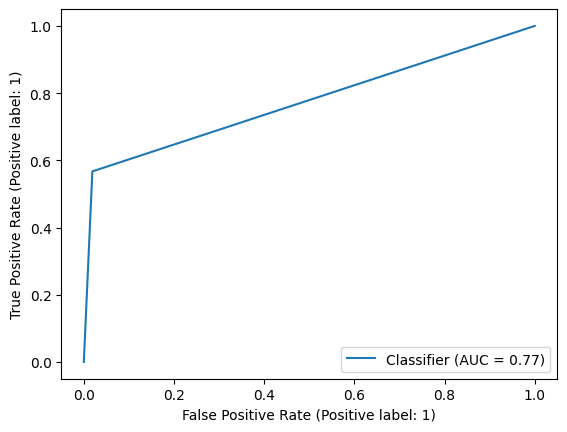

Precision-Recall Curve:


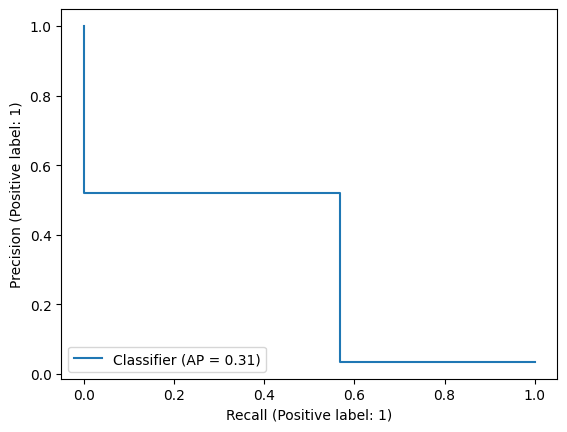

In [52]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

#### Dengan Resampling

In [128]:
%%time
start = time.time()
default_cart_resampled.fit(X_train_resampled, y_train_resampled)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 25.61 seconds
CPU times: user 25.5 s, sys: 160 ms, total: 25.6 s
Wall time: 25.6 s


In [129]:
%%time
start = time.time()
y_pred_val_resampled = default_cart_resampled.predict(X_val)
y_prob_val_resampled = default_cart_resampled.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 0.73 seconds
CPU times: user 549 ms, sys: 184 ms, total: 733 ms
Wall time: 731 ms


              precision    recall  f1-score   support

   Non Fraud       0.98      0.97      0.98    170963
       Fraud       0.40      0.59      0.48      6199

    accuracy                           0.95    177162
   macro avg       0.69      0.78      0.73    177162
weighted avg       0.96      0.95      0.96    177162

Confusion Matrix:
[[165411   5552]
 [  2524   3675]]
AUC: 0.78
ROC Curve:


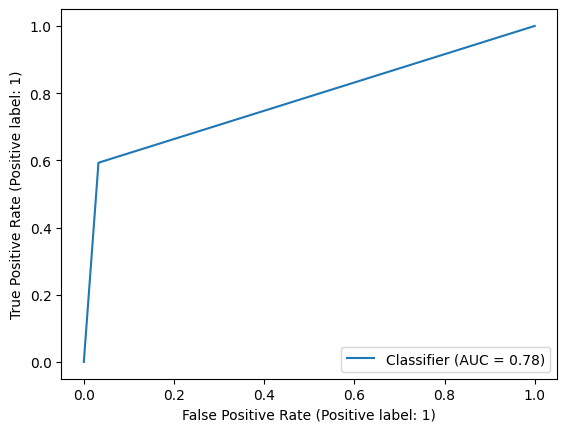

Precision-Recall Curve:


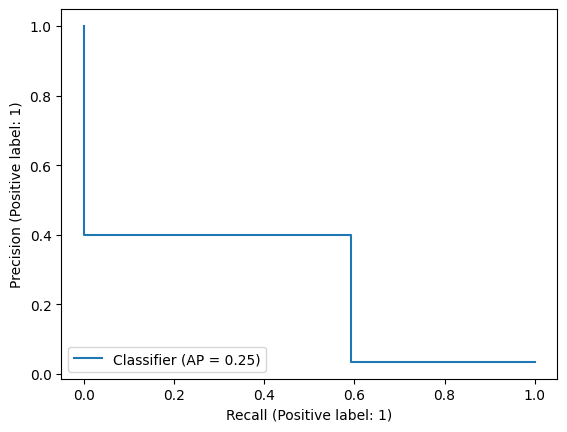

In [130]:
print(classification_report(y_val, y_pred_val_resampled, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val_resampled)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val_resampled), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val_resampled)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val_resampled)

### RF

In [31]:
default_rf = RandomForestClassifier(random_state=123)
default_rf_resampled = RandomForestClassifier(random_state=123)

#### Tanpa Resampling

In [32]:
%%time
start = time.time()
default_rf.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 179.14 seconds
CPU times: user 2min 58s, sys: 282 ms, total: 2min 59s
Wall time: 2min 59s


In [33]:
# %%time
# start = time.time()
# y_pred_train = default_rf.predict(X_train)
# y_prob_train = default_rf.predict_proba(X_train)[:,1]
# end = time.time()

# print(f"Elapsed time: {round(end - start, 2)} seconds")

In [34]:
# print(classification_report(y_train, y_pred_train, target_names = ['Non Fraud', 'Fraud']))
# print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred_train)}")
# print(f"AUC: {round(roc_auc_score(y_train, y_prob_train), 2)}")
# print(f"ROC Curve:")
# roc(y_train, y_prob_train)
# print(f"Precision-Recall Curve:")
# pr_curve(y_train, y_prob_train)

In [35]:
%%time
start = time.time()
y_pred_val = default_rf.predict(X_val)
y_prob_val = default_rf.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 13.13 seconds
CPU times: user 12.9 s, sys: 184 ms, total: 13.1 s
Wall time: 13.1 s


              precision    recall  f1-score   support

   Non Fraud       0.98      1.00      0.99    170963
       Fraud       0.94      0.44      0.60      6199

    accuracy                           0.98    177162
   macro avg       0.96      0.72      0.79    177162
weighted avg       0.98      0.98      0.98    177162

Confusion Matrix:
[[170792    171]
 [  3470   2729]]
AUC: 0.93
ROC Curve:


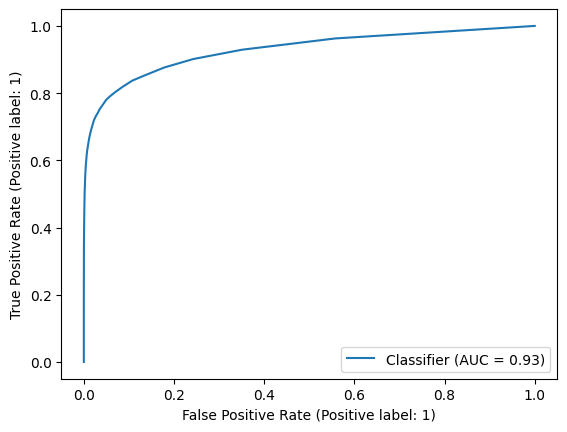

Precision-Recall Curve:


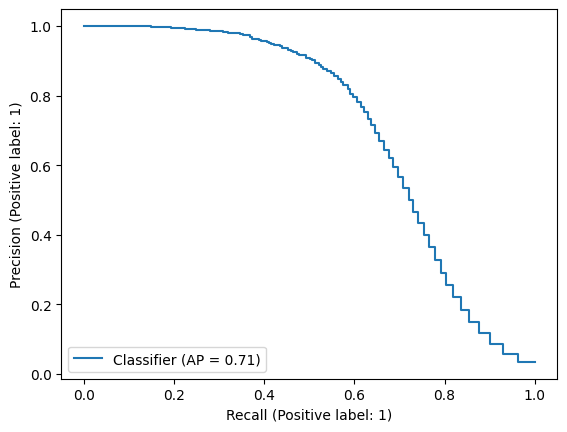

In [36]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

#### Dengan Resampling

In [131]:
%%time
start = time.time()
default_rf_resampled.fit(X_train_resampled, y_train_resampled)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 101.64 seconds
CPU times: user 1min 41s, sys: 176 ms, total: 1min 41s
Wall time: 1min 41s


In [132]:
%%time
start = time.time()
y_pred_val_resampled = default_rf_resampled.predict(X_val)
y_prob_val_resampled = default_rf_resampled.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 12.64 seconds
CPU times: user 12.4 s, sys: 260 ms, total: 12.6 s
Wall time: 12.6 s


              precision    recall  f1-score   support

   Non Fraud       0.98      1.00      0.99    170963
       Fraud       0.84      0.56      0.67      6199

    accuracy                           0.98    177162
   macro avg       0.91      0.78      0.83    177162
weighted avg       0.98      0.98      0.98    177162

Confusion Matrix:
[[170313    650]
 [  2726   3473]]
AUC: 0.94
ROC Curve:


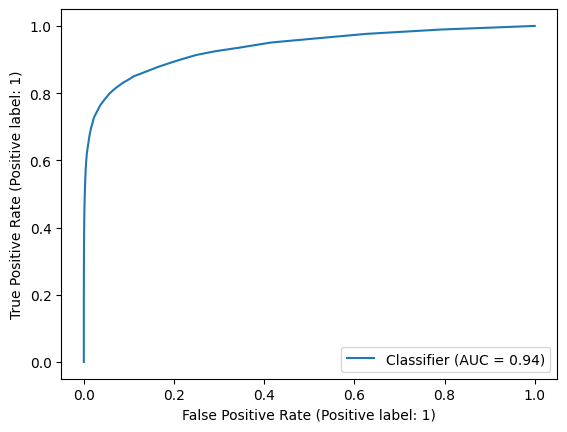

Precision-Recall Curve:


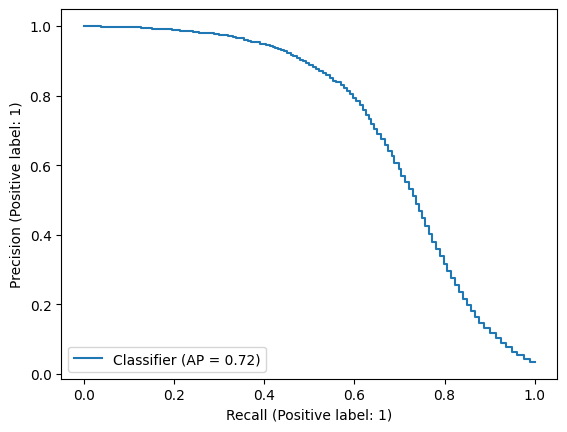

In [133]:
print(classification_report(y_val, y_pred_val_resampled, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val_resampled)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val_resampled), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val_resampled)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val_resampled)

### XGB

In [40]:
default_xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1)
default_xgb_resampled = XGBClassifier(objective='binary:logistic', n_jobs=-1)

#### Tanpa Resampling

In [41]:
%%time
start = time.time()
default_xgb.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

[10:51:14] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time: 60.42 seconds
CPU times: user 14min 38s, sys: 1.01 s, total: 14min 39s
Wall time: 1min


In [42]:
# %%time
# start = time.time()
# y_pred_train = default_xgb.predict(X_train)
# y_prob_train = default_xgb.predict_proba(X_train)[:,1]
# end = time.time()

# print(f"Elapsed time: {round(end - start, 2)} seconds")

In [43]:
# print(classification_report(y_train, y_pred_train, target_names = ['Non Fraud', 'Fraud']))
# print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred_train)}")
# print(f"AUC: {round(roc_auc_score(y_train, y_prob_train), 2)}")
# print(f"ROC Curve:")
# roc(y_train, y_prob_train)
# print(f"Precision-Recall Curve:")
# pr_curve(y_train, y_prob_train)

In [44]:
%%time
start = time.time()
y_pred_val = default_xgb.predict(X_val)
y_prob_val = default_xgb.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 1.17 seconds
CPU times: user 3.94 s, sys: 288 ms, total: 4.22 s
Wall time: 1.17 s


              precision    recall  f1-score   support

   Non Fraud       0.98      1.00      0.99    170963
       Fraud       0.91      0.47      0.62      6199

    accuracy                           0.98    177162
   macro avg       0.94      0.74      0.81    177162
weighted avg       0.98      0.98      0.98    177162

Confusion Matrix:
[[170668    295]
 [  3272   2927]]
AUC: 0.94
ROC Curve:


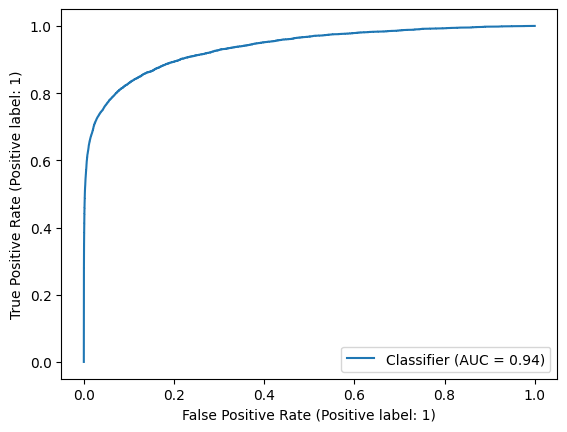

Precision-Recall Curve:


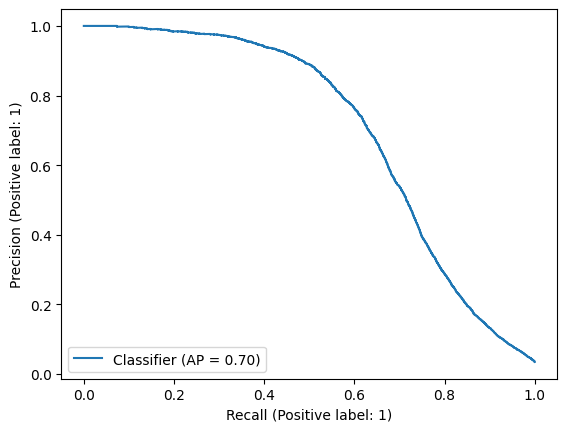

In [45]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

#### With Resampling

In [134]:
%%time
start = time.time()
default_xgb_resampled.fit(X_train_resampled, y_train_resampled)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

[12:04:30] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time: 39.65 seconds
CPU times: user 10min 12s, sys: 454 ms, total: 10min 13s
Wall time: 39.7 s


In [135]:
%%time
start = time.time()
y_pred_val_resampled = default_xgb_resampled.predict(X_val)
y_prob_val_resampled = default_xgb_resampled.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 1.14 seconds
CPU times: user 3.74 s, sys: 308 ms, total: 4.05 s
Wall time: 1.14 s


              precision    recall  f1-score   support

   Non Fraud       0.99      0.96      0.97    170963
       Fraud       0.39      0.76      0.51      6199

    accuracy                           0.95    177162
   macro avg       0.69      0.86      0.74    177162
weighted avg       0.97      0.95      0.96    177162

Confusion Matrix:
[[163499   7464]
 [  1493   4706]]
AUC: 0.94
ROC Curve:


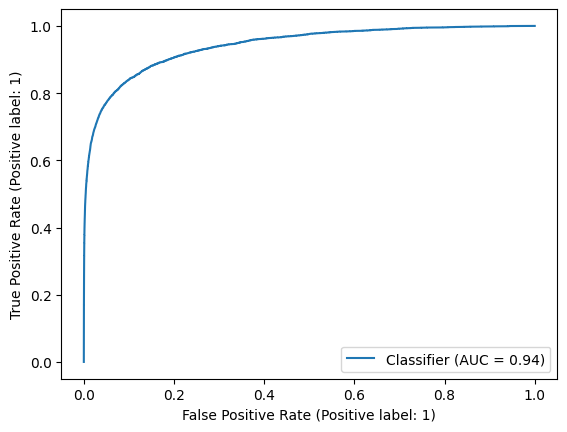

Precision-Recall Curve:


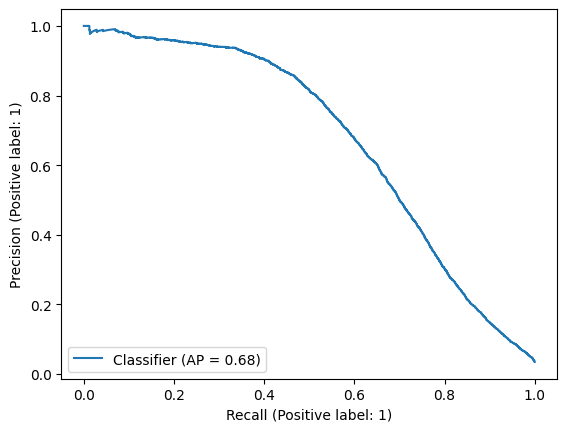

In [136]:
print(classification_report(y_val, y_pred_val_resampled, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val_resampled)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val_resampled), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val_resampled)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val_resampled)

## Parameter Tuning

### CART

In [22]:
cart = DecisionTreeClassifier(class_weight='balanced', random_state=123)
max_depth_range = [i for i in range(10, 51, 10)]
min_samples_split_range = [i for i in range(5, 26, 5)]
min_samples_leaf_range = [i for i in range(5, 26, 5)]

param_grid = {
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'min_samples_leaf': min_samples_leaf_range
}

# scoring = {
#     'ap' : 'average_precision',
#     'auc' : 'roc_auc',
#     'f1' : 'f1',
#     'pr' : 'precision',
#     'rc' : 'recall'
#     }

grid_search = GridSearchCV(
                    estimator = cart,
                    param_grid = param_grid,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring = 'roc_auc',
                    n_jobs = -1,
                    verbose = 1
                    )

#### Tanpa Resampling

In [23]:
%%time
start = time.time()
gs_cart = grid_search.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {round((end - start), 2)} seconds")

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Elapsed time: 1432.25 seconds
CPU times: user 19.3 s, sys: 2.3 s, total: 21.6 s
Wall time: 23min 52s


In [24]:
best_params_cart = gs_cart.best_params_
print(f'Best hyperparameter: {best_params_cart}')
print("Best AUC score: {:.2f}".format(gs_cart.best_score_))

Best hyperparameter: {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 5}
Best AUC score: 0.87


In [25]:
%%time
start = time.time()
best_cart = gs_cart.best_estimator_
# best_cart = DecisionTreeClassifier(**best_params_cart)
# best_cart.fit(X_train_resampled, y_train_resampled)
# best_cart.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 2.384185791015625e-06 seconds
CPU times: user 96 µs, sys: 0 ns, total: 96 µs
Wall time: 140 µs


In [157]:
# %%time
# start = time.time()
# y_pred_train = best_cart.predict(X_train)
# y_prob_train = best_cart.predict_proba(X_train)[:,1]
# end = time.time()

# print(f"Elapsed time: {end - start} seconds")

In [ ]:
# print(classification_report(y_train, y_pred_train, target_names = ['Non Fraud', 'Fraud']))
# print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred_train)}")
# print(f"AUC: {round(roc_auc_score(y_train, y_prob_train), 2)}")
# print(f"ROC Curve:")
# roc(y_train, y_prob_train)
# print(f"Precision-Recall Curve:")
# pr_curve(y_train, y_prob_train)

In [26]:
%%time
start = time.time()
y_pred_val = best_cart.predict(X_val)
y_prob_val = best_cart.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 0.7395548820495605 seconds
CPU times: user 533 ms, sys: 207 ms, total: 740 ms
Wall time: 740 ms


              precision    recall  f1-score   support

   Non Fraud       0.99      0.84      0.91    170963
       Fraud       0.15      0.77      0.26      6199

    accuracy                           0.84    177162
   macro avg       0.57      0.81      0.58    177162
weighted avg       0.96      0.84      0.89    177162

Confusion Matrix:
[[144410  26553]
 [  1401   4798]]
AUC: 0.88
ROC Curve:


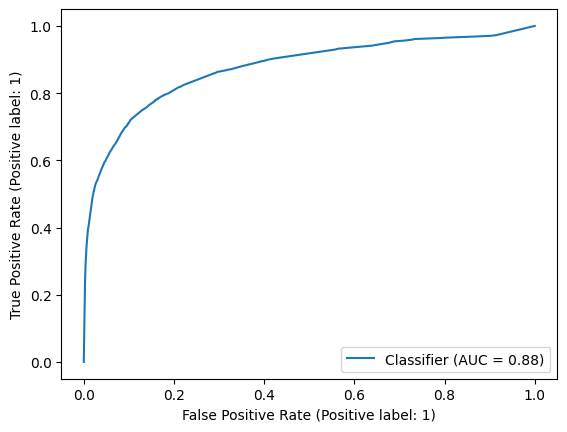

Precision-Recall Curve:


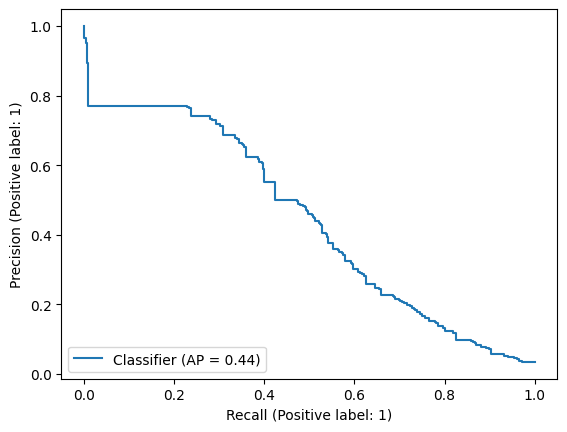

In [27]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

#### Dengan Resampling

In [28]:
%%time
start = time.time()
gs_cart_resampled = grid_search.fit(X_train_resampled, y_train_resampled)
end = time.time()

print(f"Elapsed time: {round((end - start), 2)} seconds")

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Elapsed time: 993.49 seconds
CPU times: user 24 s, sys: 533 ms, total: 24.6 s
Wall time: 16min 33s


In [29]:
best_params_cart = gs_cart_resampled.best_params_
print(f'Best hyperparameter: {best_params_cart}')
print("Best AUC score: {:.2f}".format(gs_cart_resampled.best_score_))

Best hyperparameter: {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best AUC score: 0.98


In [30]:
%%time
start = time.time()
best_cart_resampled = gs_cart_resampled.best_estimator_
# best_cart = DecisionTreeClassifier(**best_params_cart)
# best_cart.fit(X_train_resampled, y_train_resampled)
# best_cart.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 2.384185791015625e-06 seconds
CPU times: user 139 µs, sys: 0 ns, total: 139 µs
Wall time: 148 µs


In [31]:
%%time
start = time.time()
y_pred_val_resampled = best_cart_resampled.predict(X_val)
y_prob_val_resampled = best_cart_resampled.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 0.7678887844085693 seconds
CPU times: user 529 ms, sys: 240 ms, total: 768 ms
Wall time: 768 ms


              precision    recall  f1-score   support

   Non Fraud       0.99      0.95      0.97    170963
       Fraud       0.31      0.65      0.42      6199

    accuracy                           0.94    177162
   macro avg       0.65      0.80      0.69    177162
weighted avg       0.96      0.94      0.95    177162

Confusion Matrix:
[[162145   8818]
 [  2182   4017]]
AUC: 0.8
ROC Curve:


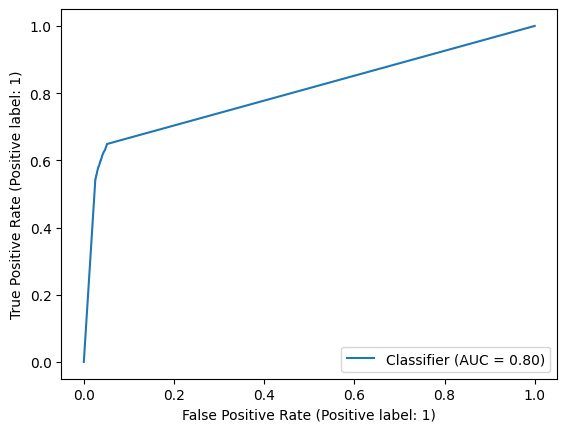

Precision-Recall Curve:


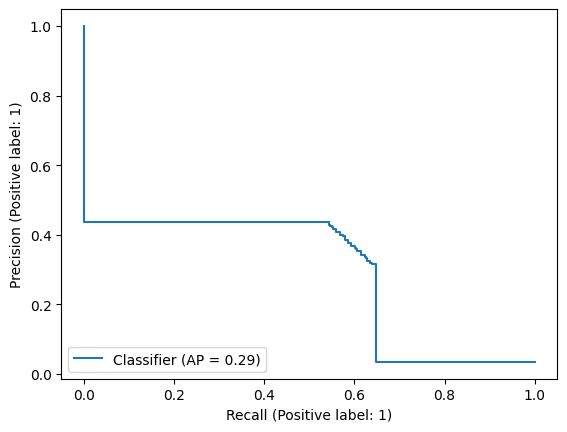

In [32]:
print(classification_report(y_val, y_pred_val_resampled, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val_resampled)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val_resampled), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val_resampled)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val_resampled)

### RF

In [259]:
rf = RandomForestClassifier(class_weight='balanced', random_state=123)
n_estimator_range = [i for i in range(200, 501, 100)]
max_depth_range = [i for i in range(40, 61, 10)]
# min_samples_split_range = [i for i in range(5, 21, 5)]
# min_samples_leaf_range = [i for i in range(5, 21, 5)]

param_grid = {
    'n_estimators': n_estimator_range,
    'max_depth': max_depth_range
    # 'min_samples_split': min_samples_split_range,
    # 'min_samples_leaf': min_samples_leaf_range,
}

# scoring = {
#     'ap' : 'average_precision',
#     'f1' : 'f1',
#     'pr' : 'precision',
#     'rc' : 'recall',
#     'auc' : 'roc_auc'
#     }

grid_search = GridSearchCV(
                    estimator = rf,
                    param_grid = param_grid,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring = 'roc_auc',
                    n_jobs = -1,
                    verbose = 1
                )

#### Tanpa Resampling

In [260]:
%%time
start = time.time()
gs_rf = grid_search.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {round((end - start), 2)} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Elapsed time: 3446.8 seconds
CPU times: user 11min 17s, sys: 1.45 s, total: 11min 18s
Wall time: 57min 26s


In [261]:
best_params_rf = gs_rf.best_params_
print(f'Best hyperparameter: {best_params_rf}')
print("Best AUC: {:.2f}".format(gs_rf.best_score_))

Best hyperparameter: {'max_depth': 40, 'n_estimators': 500}
Best AUC: 0.94


In [262]:
%%time
start = time.time()
best_rf = gs_rf.best_estimator_
# best_rf = RandomForestClassifier(**best_params_rf)
# best_rf.fit(X_train_resampled, y_train_resampled)
# best_rf.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 2.1457672119140625e-06 seconds
CPU times: user 189 µs, sys: 0 ns, total: 189 µs
Wall time: 161 µs


In [ ]:
# %%time
# start = time.time()
# y_pred_train = best_rf.predict(X_train)
# y_prob_train = best_rf.predict_proba(X_train)[:,1]
# end = time.time()

# print(f"Elapsed time: {end - start} seconds")

In [ ]:
# print(classification_report(y_train, y_pred_train, target_names = ['Non Fraud', 'Fraud']))
# print(f"Confusion Matrix:\n{confusion_matrix(y_train, y_pred_train)}")
# print(f"AUC: {round(roc_auc_score(y_train, y_prob_train), 2)}")
# print(f"ROC Curve:")
# roc(y_train, y_prob_train)
# print(f"Precision-Recall Curve:")
# pr_curve(y_train, y_prob_train)

In [263]:
%%time
start = time.time()
y_pred_val = best_rf.predict(X_val)
y_prob_val = best_rf.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 57.91214323043823 seconds
CPU times: user 57.7 s, sys: 180 ms, total: 57.9 s
Wall time: 57.9 s


              precision    recall  f1-score   support

   Non Fraud       0.98      1.00      0.99    170963
       Fraud       0.94      0.42      0.58      6199

    accuracy                           0.98    177162
   macro avg       0.96      0.71      0.78    177162
weighted avg       0.98      0.98      0.97    177162

Confusion Matrix:
[[170805    158]
 [  3622   2577]]
AUC: 0.94
ROC Curve:


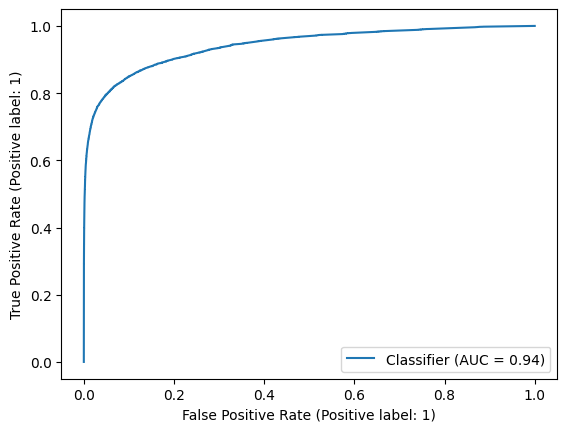

Precision-Recall Curve:


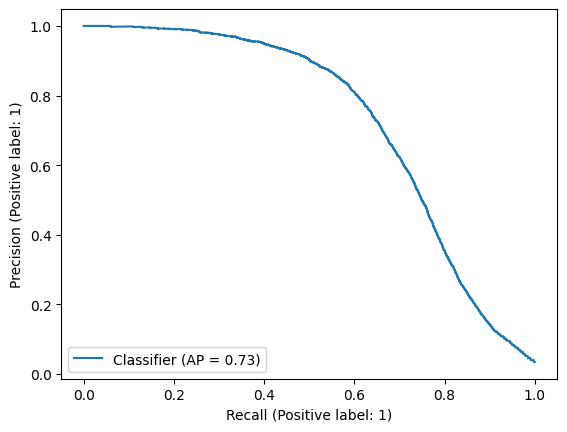

In [264]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

#### Dengan Resampling

In [265]:
%%time
start = time.time()
gs_rf_resampled = grid_search.fit(X_train_resampled, y_train_resampled)
end = time.time()

print(f"Elapsed time: {round((end - start), 2)} seconds")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Elapsed time: 2406.0 seconds
CPU times: user 5min 7s, sys: 1.51 s, total: 5min 9s
Wall time: 40min 6s


In [266]:
best_params_rf = gs_rf_resampled.best_params_
print(f'Best hyperparameter: {best_params_rf}')
print("Best AUC score: {:.2f}".format(gs_rf_resampled.best_score_))

Best hyperparameter: {'max_depth': 60, 'n_estimators': 300}
Best AUC score: 1.00


In [267]:
%%time
start = time.time()
best_rf_resampled = gs_rf_resampled.best_estimator_
# best_cart = DecisionTreeClassifier(**best_params_cart)
# best_cart.fit(X_train_resampled, y_train_resampled)
# best_cart.fit(X_train, y_train)
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 4.5299530029296875e-06 seconds
CPU times: user 221 µs, sys: 0 ns, total: 221 µs
Wall time: 189 µs


In [268]:
%%time
start = time.time()
y_pred_val_resampled = best_rf_resampled.predict(X_val)
y_prob_val_resampled = best_rf_resampled.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {end - start} seconds")

Elapsed time: 37.504889726638794 seconds
CPU times: user 37.3 s, sys: 236 ms, total: 37.5 s
Wall time: 37.5 s


              precision    recall  f1-score   support

   Non Fraud       0.98      1.00      0.99    170963
       Fraud       0.85      0.55      0.67      6199

    accuracy                           0.98    177162
   macro avg       0.92      0.78      0.83    177162
weighted avg       0.98      0.98      0.98    177162

Confusion Matrix:
[[170350    613]
 [  2761   3438]]
AUC: 0.94
ROC Curve:


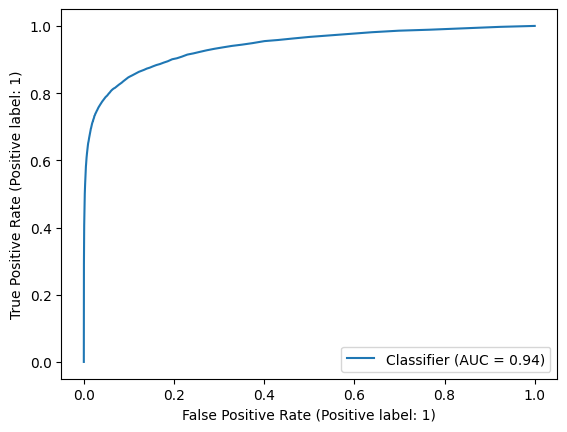

Precision-Recall Curve:


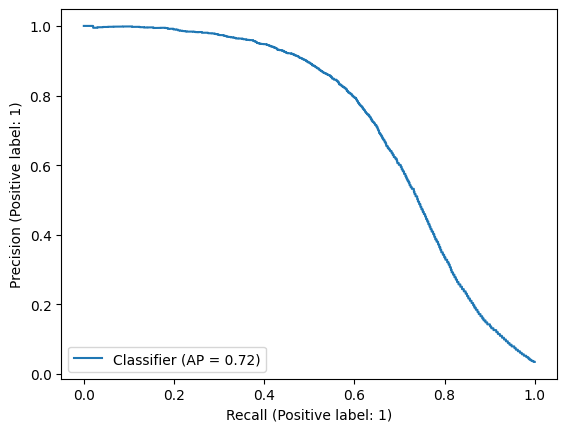

In [269]:
print(classification_report(y_val, y_pred_val_resampled, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val_resampled)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val_resampled), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val_resampled)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val_resampled)

### XGB

In [185]:
xgb = XGBClassifier(objective='binary:logistic', n_jobs=8)


param_grid = {
    'max_depth': [10, 15, 20],
    'learning_rate': [0.05, 0.01],
    'n_estimators': [50, 100],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.4, 0.6]
}

grid_search = GridSearchCV(
                    estimator = xgb,
                    param_grid = param_grid,
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring = 'roc_auc',
                    n_jobs = -1,
                    verbose = 1
                )

#### Tanpa Resampling

In [274]:
xgb = XGBClassifier(
    learning_rate =0.1,
    n_estimators=500,
    max_depth=10,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    eval_metric='auc',
    n_jobs=-1,
    seed=123)

In [275]:
%%time
start = time.time()
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
        early_stopping_rounds=10)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

[0]	validation_0-auc:0.84689
[1]	validation_0-auc:0.85678
[2]	validation_0-auc:0.85974
[3]	validation_0-auc:0.86347
[4]	validation_0-auc:0.86936
[5]	validation_0-auc:0.87291
[6]	validation_0-auc:0.87452
[7]	validation_0-auc:0.87628
[8]	validation_0-auc:0.87788
[9]	validation_0-auc:0.87830
[10]	validation_0-auc:0.88022
[11]	validation_0-auc:0.88211
[12]	validation_0-auc:0.88393
[13]	validation_0-auc:0.88587
[14]	validation_0-auc:0.88732
[15]	validation_0-auc:0.88865
[16]	validation_0-auc:0.88990
[17]	validation_0-auc:0.89107
[18]	validation_0-auc:0.89241
[19]	validation_0-auc:0.89491
[20]	validation_0-auc:0.89655
[21]	validation_0-auc:0.89865
[22]	validation_0-auc:0.89968
[23]	validation_0-auc:0.90065
[24]	validation_0-auc:0.90200
[25]	validation_0-auc:0.90276
[26]	validation_0-auc:0.90417
[27]	validation_0-auc:0.90540
[28]	validation_0-auc:0.90671
[29]	validation_0-auc:0.90821
[30]	validation_0-auc:0.90986
[31]	validation_0-auc:0.91104
[32]	validation_0-auc:0.91243
[33]	validation_0-au

In [276]:
%%time
start = time.time()
y_pred_val = xgb.predict(X_val)
y_prob_val = xgb.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 1.65 seconds
CPU times: user 11.8 s, sys: 308 ms, total: 12.1 s
Wall time: 1.65 s


              precision    recall  f1-score   support

   Non Fraud       0.99      1.00      0.99    170963
       Fraud       0.96      0.59      0.73      6199

    accuracy                           0.98    177162
   macro avg       0.97      0.79      0.86    177162
weighted avg       0.98      0.98      0.98    177162

Confusion Matrix:
[[170791    172]
 [  2540   3659]]
AUC: 0.97
ROC Curve:


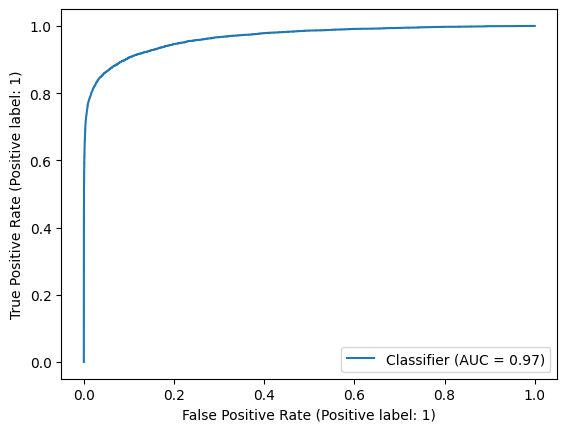

Precision-Recall Curve:


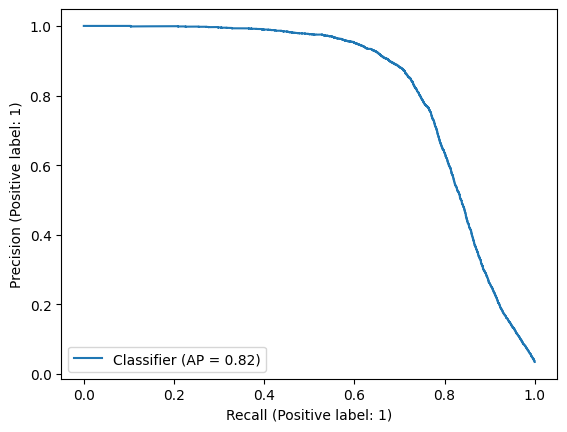

In [277]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

#### Dengan Resampling

In [271]:
%%time
start = time.time()
xgb2 = xgb.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)], 
        early_stopping_rounds=10)
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

[0]	validation_0-auc:0.86440
[1]	validation_0-auc:0.88508
[2]	validation_0-auc:0.89438
[3]	validation_0-auc:0.89719
[4]	validation_0-auc:0.90089
[5]	validation_0-auc:0.90359
[6]	validation_0-auc:0.90518
[7]	validation_0-auc:0.90845
[8]	validation_0-auc:0.90968
[9]	validation_0-auc:0.91105
[10]	validation_0-auc:0.91168
[11]	validation_0-auc:0.91276
[12]	validation_0-auc:0.91315
[13]	validation_0-auc:0.91396
[14]	validation_0-auc:0.91485
[15]	validation_0-auc:0.91580
[16]	validation_0-auc:0.91638
[17]	validation_0-auc:0.91752
[18]	validation_0-auc:0.91838
[19]	validation_0-auc:0.92034
[20]	validation_0-auc:0.92182
[21]	validation_0-auc:0.92334
[22]	validation_0-auc:0.92465
[23]	validation_0-auc:0.92573
[24]	validation_0-auc:0.92777
[25]	validation_0-auc:0.92900
[26]	validation_0-auc:0.92970
[27]	validation_0-auc:0.93107
[28]	validation_0-auc:0.93196
[29]	validation_0-auc:0.93254
[30]	validation_0-auc:0.93341
[31]	validation_0-auc:0.93393
[32]	validation_0-auc:0.93479
[33]	validation_0-au

In [272]:
%%time
start = time.time()
y_pred_val = xgb2.predict(X_val)
y_prob_val = xgb2.predict_proba(X_val)[:,1]
end = time.time()

print(f"Elapsed time: {round(end - start, 2)} seconds")

Elapsed time: 1.48 seconds
CPU times: user 9.03 s, sys: 280 ms, total: 9.31 s
Wall time: 1.48 s


              precision    recall  f1-score   support

   Non Fraud       0.99      0.99      0.99    170963
       Fraud       0.67      0.75      0.71      6199

    accuracy                           0.98    177162
   macro avg       0.83      0.87      0.85    177162
weighted avg       0.98      0.98      0.98    177162

Confusion Matrix:
[[168650   2313]
 [  1552   4647]]
AUC: 0.96
ROC Curve:


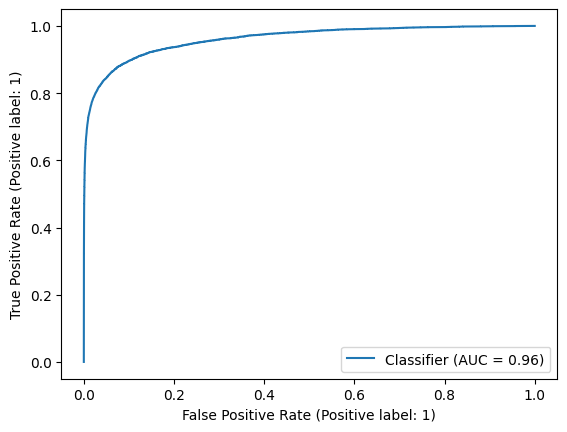

Precision-Recall Curve:


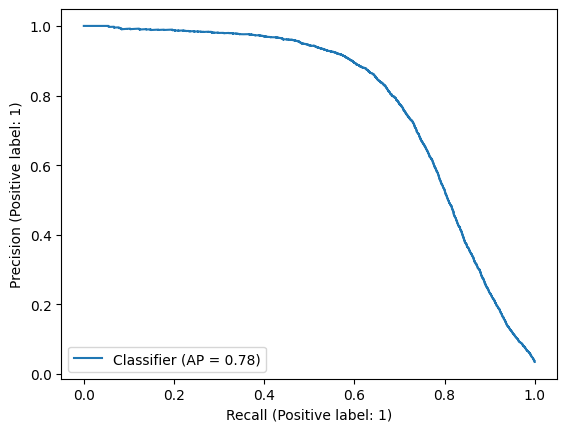

In [273]:
print(classification_report(y_val, y_pred_val, target_names = ['Non Fraud', 'Fraud']))
print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred_val)}")
print(f"AUC: {round(roc_auc_score(y_val, y_prob_val), 2)}")
print(f"ROC Curve:")
roc(y_val, y_prob_val)
print(f"Precision-Recall Curve:")
pr_curve(y_val, y_prob_val)

# Testing

## Import Test Data

In [297]:
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [298]:
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

## Data Preprocessing

In [299]:
test_df = reduce_memory_usage(test_df)

Memory usage decreased to 565.37 Mb (66.3% reduction)


In [300]:
resumetable(test_df)

Dataset Shape: (506691, 433)


,Name,dtypes,# Missing,% Missing,Uniques,Entropy
0,TransactionID,int32,0,0.00,506691,18.95
1,TransactionDT,int32,0,0.00,494686,18.90
2,TransactionAmt,float16,0,0.00,7343,7.93
3,ProductCD,object,0,0.00,5,1.37
4,card1,int16,0,0.00,13244,9.95
5,card2,float16,8654,1.47,497,6.28
6,card3,float16,3002,0.51,115,0.81
7,card4,object,3086,0.52,4,1.05
8,card5,float16,4547,0.77,102,2.63
9,card6,object,3007,0.51,3,0.79


In [301]:
test_df = feature_eng(test_df)

In [302]:
resumetable(test_df)

Dataset Shape: (506691, 456)


,Name,dtypes,# Missing,% Missing,Uniques,Entropy
0,TransactionID,int32,0,0.00,506691,18.95
1,TransactionDT,int32,0,0.00,494686,18.90
2,TransactionAmt,float16,0,0.00,7343,7.93
3,ProductCD,object,0,0.00,5,1.37
4,card1,int16,0,0.00,13244,9.95
5,card2,float16,8654,1.47,497,6.28
6,card3,float16,3002,0.51,115,0.81
7,card4,object,3086,0.52,4,1.05
8,card5,float16,4547,0.77,102,2.63
9,card6,object,3007,0.51,3,0.79


In [303]:
test_df.drop(columns_to_drop, axis=1, inplace=True)

In [304]:
test_df.drop('TransactionID', axis=1, inplace=True)

In [305]:
resumetable(test_df)

Dataset Shape: (506691, 276)


,Name,dtypes,# Missing,% Missing,Uniques,Entropy
0,TransactionDT,int32,0,0.00,494686,18.90
1,TransactionAmt,float16,0,0.00,7343,7.93
2,ProductCD,object,0,0.00,5,1.37
3,card1,int16,0,0.00,13244,9.95
4,card2,float16,8654,1.47,497,6.28
5,card3,float16,3002,0.51,115,0.81
6,card4,object,3086,0.52,4,1.05
7,card5,float16,4547,0.77,102,2.63
8,card6,object,3007,0.51,3,0.79
9,addr1,float16,65609,11.11,292,5.10


In [306]:
test_categorical_cols = test_df.select_dtypes(include='object').columns#.tolist()
test_df[test_categorical_cols] = test_df[test_categorical_cols].fillna(value='missing')

test_numeric_cols = test_df.select_dtypes(exclude=['object']).columns#.tolist()
test_df[test_numeric_cols] = test_df[test_numeric_cols].fillna(0)

In [307]:
for f in test_df.columns:
    if test_df[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [308]:
test_df = reduce_memory_usage(test_df)

Memory usage decreased to 272.54 Mb (38.2% reduction)


## CART

In [315]:
cart_fraudprob = best_cart.predict_proba(test_df)[:,1]

In [316]:
submission = pd.DataFrame({'TransactionID': test_transaction['TransactionID'],'isFraud':cart_fraudprob})
submission["TransactionID"] = submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.210382
1,3663550,0.154790
2,3663551,0.383868
3,3663552,0.191455
4,3663553,0.705730


In [317]:
filename = 'Fraud Detection CART Test.csv'

submission.to_csv(filename, index=False)

print('Saved file: ' + filename)

Saved file: Fraud Detection CART Test.csv


## Random Forest

In [309]:
rf_fraudprob = best_rf.predict_proba(test_df)[:,1]

In [310]:
submission = pd.DataFrame({'TransactionID': test_transaction['TransactionID'],'isFraud':rf_fraudprob})
submission["TransactionID"] = submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.010
1,3663550,0.036
2,3663551,0.022
3,3663552,0.012
4,3663553,0.008


In [311]:
filename = 'Fraud Detection RF Test.csv'

submission.to_csv(filename, index=False)

print('Saved file: ' + filename)

Saved file: Fraud Detection RF Test.csv


## XGBoost

In [312]:
xgb_fraudprob = xgb.predict_proba(test_df)[:,1]

In [313]:
submission = pd.DataFrame({'TransactionID':test_transaction['TransactionID'],'isFraud':xgb_fraudprob})
submission["TransactionID"] = submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.000196
1,3663550,0.000430
2,3663551,0.001021
3,3663552,0.001155
4,3663553,0.000123


In [314]:
filename = 'Fraud Detection XGB Test.csv'

submission.to_csv(filename, index=False)

print('Saved file: ' + filename)

Saved file: Fraud Detection XGB Test.csv


# Lampiran

In [11]:
!pip install -U openpyxl

     |████████████████████████████████| 249 kB 7.6 MB/s eta 0:00:01


In [5]:
import openpyxl

filename = 'Summary Training Data.xlsx'

train_summary = resumetable(train_df)
train_summary.to_excel(filename, index=False)

print('Saved file: ' + filename)